# DeBERTa-v3-SMALL Regression Starter
This notebook is a fork from Yuto_H's great notebook [here][1]. If you like my notebook, remember to upvote Yuto's notebook too. In this notebook we add the following modifications which are explained in my discussion post [here][3]:
* Change model to `DeBERTa-v3-small` for fast experiments (Note that `xsmall` works well too)
* Increase token `max_length to 1024` (instead of 512 to include all essay text)
* Use total `train batch size = 8`, valid batch size 16 (Note `batch per gpu = 4` and we have 2xT4 GPU)
* Train `4 epochs linear` with start `LR = 1e-5` and `no warmup`
* Remove seed everything (I like randomness)
* Add `QWK metric for regression`
* Add `new tokens` to tokenizer because DeBERTa removes "new paragraph" and "double space" from essay
* `Remove dropout` for regression
* Save `full OOF` predictions
* Add `test inference` and `LB submit`
* Achieves surprising `CV = 0.822` WOW! and LB = ??? (submitting now, let's see what LB is...)

For training, this notebook averages 1 hour per fold which is 15 minutes per epoch training on 2xT4 Kaggle GPU. (Training is done in version 1. And inference and submit to LB is done in version 2).

# Version Notes
In version 1, we finetune a new DeBERTa-v3-SMALL and save it to the Kaggle dataset [here][4]. Therefore if you want to see training epoch details, view notebook version 1. This took 6 hours using Kaggle's 2xT4 GPU.

In notebook version 2, we load the saved fold models and infer test data and submit to LB. Version 2 runs quickly because it is only inference. It will run in either 6 minutes or 1 minute depending on whether we infer OOF and compute CV score again.

If we want version 2 inference to run more quickly, we can set `COMPUTE_CV = False` below, then we will not use 5 minutes to predict OOF and compute CV score. Instead we will only infer test data.

[1]: https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
[2]: https://www.kaggle.com/code/hashidoyuto/deberta-v3-base-aes2-0-infer
[3]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832
[4]: https://www.kaggle.com/datasets/cdeotte/deberta-v3-small-finetuned-v1

# Imports and Config
Import libraries and define configuration parameters here.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# True USES REGRESSION, False USES CLASSIFICATION
USE_REGRESSION = True

# VERSION NUMBER FOR NAMING OF SAVED MODELS
VER=1

# IF "LOAD_FROM" IS None, THEN WE TRAIN NEW MODELS
LOAD_FROM = "/home/zvonimir/kaggle/input/deberta-v3-small-finetuned-v1/"

# WHEN TRAINING NEW MODELS SET COMPUTE_CV = True
# WHEN LOADING MODELS, WE CAN CHOOSE True or False
COMPUTE_CV = True

In [2]:
import warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
warnings.simplefilter('ignore')

2024-05-18 08:53:07.790957: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-18 08:53:07.827163: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-18 08:53:07.968819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-18 08:53:08.522657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class PATHS:
    train_path = '/home/zvonimir/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv'
    test_path = '/home/zvonimir/kaggle/input/learning-agency-lab-automated-essay-scoring-2/test.csv'
    sub_path = '/home/zvonimir/kaggle/input/learning-agency-lab-automated-essay-scoring-2/sample_submission.csv'
    model_path = "/home/zvonimir/kaggle/input/huggingfacedebertav3variants/deberta-v3-small"

In [ ]:
# does copilot work here
# does it w
#a = 


In [4]:
class CFG:
    n_splits = 5
    seed = 42
    max_length = 1024
    lr = 1e-5
    train_batch_size = 4
    eval_batch_size = 8
    train_epochs = 4
    weight_decay = 0.01
    warmup_ratio = 0.0
    num_labels = 6

In [5]:
def seed_everything(seed):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
#seed_everything(seed=CFG.seed)

# Data Tokenization
We use `max_length = 1024` to avoid truncating majority of essays.

In [6]:
class Tokenize(object):
    def __init__(self, train, valid, tokenizer):
        self.tokenizer = tokenizer
        self.train = train
        self.valid = valid
        
    def get_dataset(self, df):
        ds = Dataset.from_dict({
                'essay_id': [e for e in df['essay_id']],
                'full_text': [ft for ft in df['full_text']],
                'label': [s for s in df['label']],
            })
        return ds
        
    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example['full_text'], truncation=True, max_length=CFG.max_length
        )
        return tokenized_inputs
    
    def __call__(self):
        train_ds = self.get_dataset(self.train)
        valid_ds = self.get_dataset(self.valid)
        
        tokenized_train = train_ds.map(
            self.tokenize_function, batched=True
        )
        tokenized_valid = valid_ds.map(
            self.tokenize_function, batched=True
        )
        
        return tokenized_train, tokenized_valid, self.tokenizer

# Compute Metrics
Below we provide compute metric function for both regression and classification. In this notebook we will use regression.

In [7]:
def compute_metrics_for_regression(eval_pred):
    
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.clip(0,5).round(0), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results

In [8]:
def compute_metrics_for_classification(eval_pred):
    
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.argmax(-1), weights='quadratic')
    results = {
        'qwk': qwk
    }
    return results

# Load Data and Set Fold
For our label, we will use `label = score - 1`. Then the labels will range from 0 to 5. For regression, we convert the label to `float32`. For classification, we would convert to `int32`.

In [9]:
data = pd.read_csv(PATHS.train_path)
data['label'] = data['score'].apply(lambda x: x-1)
if USE_REGRESSION: data["label"] = data["label"].astype('float32') 
else: data["label"] = data["label"].astype('int32') 

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val_index) in enumerate(skf.split(data, data["score"])):
    data.loc[val_index, "fold"] = i
data.head()

,essay_id,full_text,score,label,fold
0,000d118,Many people have car where they live. The thin...,3,2.0,3.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,2.0,4.0
2,001ab80,People always wish they had the same technolog...,4,3.0,1.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,2.0,2.0


# Set Training Args
We use `fp16=True` which uses mixed precision and uses less GPU VRAM and makes training faster. We use `per_device_train_batch_size = (8 / number of gpus)` because we want total train batch size to be 8. With Kaggle T4, we have 2xT4 GPUs and use `per_device_train_batch_size = 4`.

In [10]:
training_args = TrainingArguments(
    output_dir=f'output_v{VER}',
    fp16=True,
    learning_rate=CFG.lr,
    per_device_train_batch_size=CFG.train_batch_size,
    per_device_eval_batch_size=CFG.eval_batch_size,
    num_train_epochs=CFG.train_epochs,
    weight_decay=CFG.weight_decay,
    evaluation_strategy='epoch',
    metric_for_best_model='qwk',
    save_strategy='epoch',
    save_total_limit=1,
    load_best_model_at_end=True,
    report_to='none',
    warmup_ratio=CFG.warmup_ratio,
    lr_scheduler_type='linear', # "cosine" or "linear" or "constant"
    optim='adamw_torch',
    logging_first_step=True,
)

# K Fold Training
We add new tokens for ("\n") new paragraph and (" "*2) double space because the default DeBERTa tokenizer removes these but these are helpful for scoring essays. We remove dropout from our model because this does not work well when using regression. Read discussion [here][1]

[1]: https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

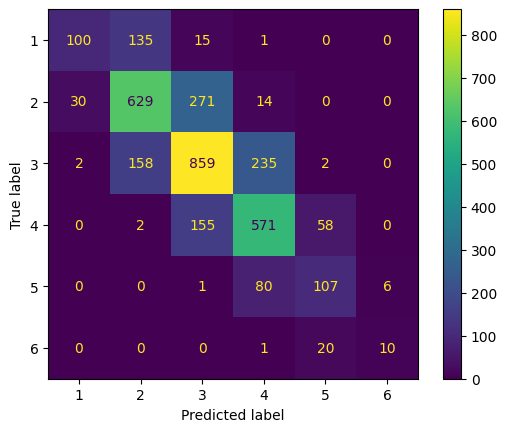

Map:   0%|          | 0/13845 [00:00<?, ? examples/s]

Map:   0%|          | 0/3462 [00:00<?, ? examples/s]

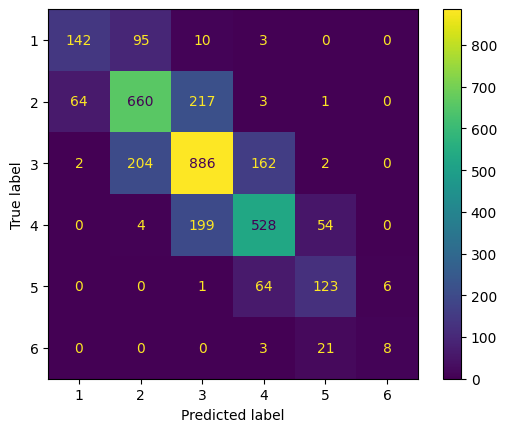

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

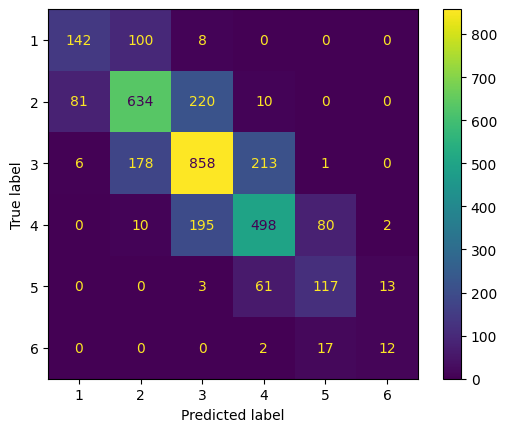

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

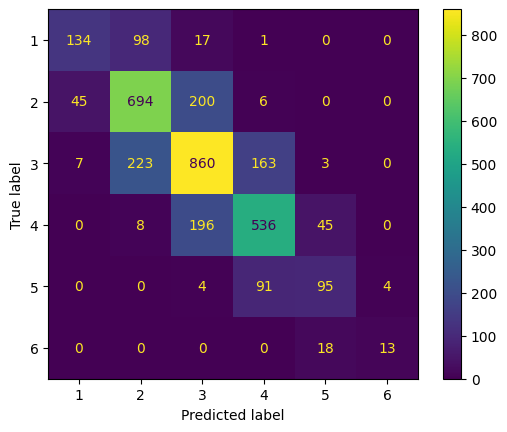

Map:   0%|          | 0/13846 [00:00<?, ? examples/s]

Map:   0%|          | 0/3461 [00:00<?, ? examples/s]

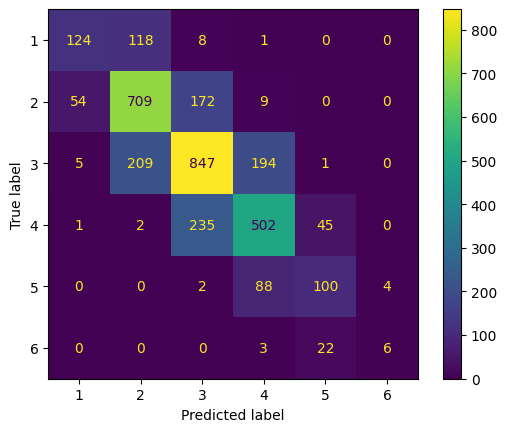

In [11]:
if COMPUTE_CV:
    for fold in range(len(data['fold'].unique())):

        # GET TRAIN AND VALID DATA
        train = data[data['fold'] != fold]
        valid = data[data['fold'] == fold].copy()

        # ADD NEW TOKENS for ("\n") new paragraph and (" "*2) double space 
        tokenizer = AutoTokenizer.from_pretrained(PATHS.model_path)
        tokenizer.add_tokens([AddedToken("\n", normalized=False)])
        tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])
        tokenize = Tokenize(train, valid, tokenizer)
        tokenized_train, tokenized_valid, _ = tokenize()

        # REMOVE DROPOUT FROM REGRESSION
        config = AutoConfig.from_pretrained(PATHS.model_path)
        if USE_REGRESSION:
            config.attention_probs_dropout_prob = 0.0 
            config.hidden_dropout_prob = 0.0 
            config.num_labels = 1 
        else: config.num_labels = CFG.num_labels 

        if LOAD_FROM:
            model = AutoModelForSequenceClassification.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
        else:
            model = AutoModelForSequenceClassification.from_pretrained(PATHS.model_path, config=config)
            model.resize_token_embeddings(len(tokenizer))

        # TRAIN WITH TRAINER
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        if USE_REGRESSION: compute_metrics = compute_metrics_for_regression
        else: compute_metrics = compute_metrics_for_classification
        trainer = Trainer( 
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_valid,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics
        )
        if LOAD_FROM is None:
            trainer.train()

        # PLOT CONFUSION MATRIX
        y_true = valid['score'].values
        predictions0 = trainer.predict(tokenized_valid).predictions
        if USE_REGRESSION: predictions = predictions0.round(0) + 1
        else: predictions = predictions0.argmax(axis=1) + 1 
        cm = confusion_matrix(y_true, predictions, labels=[x for x in range(1,7)])
        draw_cm = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=[x for x in range(1,7)])
        draw_cm.plot()
        plt.show()

        # SAVE FOLD MODEL AND TOKENIZER
        if LOAD_FROM is None:
            trainer.save_model(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
            tokenizer.save_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')

        # SAVE OOF PREDICTIONS
        if USE_REGRESSION: 
            valid['pred'] = predictions0 + 1 
        else:
            COLS = [f'p{x}' for x in range(CFG.num_labels)] 
            valid[COLS] = predictions0 
        valid.to_csv(f'valid_df_fold_{fold}_v{VER}.csv', index=False)

# Overall CV Score

In [12]:
if COMPUTE_CV:
    dfs = []
    for k in range(CFG.n_splits):
        dfs.append( pd.read_csv(f'valid_df_fold_{k}_v{VER}.csv') )
        os.system(f'rm valid_df_fold_{k}_v{VER}.csv')
    dfs = pd.concat(dfs)
    dfs.to_csv(f'valid_df_v{VER}.csv',index=False)
    print('Valid OOF shape:', dfs.shape )
    display( dfs.head() )

Valid OOF shape: (17307, 6)


,essay_id,full_text,score,label,fold,pred
0,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.0,3.587891
1,0033037,The posibilty of a face reconizing computer wo...,2,1.0,0.0,2.446289
2,0066c7c,My position on driveless cars are bad because ...,2,1.0,0.0,2.494141
3,0072128,"Imagine a world without garages, gastations, o...",4,3.0,0.0,3.894531
4,0079f2a,In the text the author uses facts that people ...,2,1.0,0.0,1.571289


In [13]:
if COMPUTE_CV:
    if USE_REGRESSION:
        m = cohen_kappa_score(dfs.score.values, dfs.pred.values.clip(1,6).round(0), weights='quadratic')
    else:
        m = cohen_kappa_score(dfs.score.values, dfs.iloc[:,-6:].values.argmax(axis=1)+1, weights='quadratic')
    print('Overall QWK CV =',m)

Overall QWK CV = 0.8222424826800401


# Infer Test Data
We infer test data using Hugging Face trainer and load our saved best fold models.

In [14]:
test = pd.read_csv(PATHS.test_path)
print('Test shape:', test.shape )
test.head()

Test shape: (3, 2)


,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [15]:
all_pred = []
test['label'] = 0.0

for fold in range(CFG.n_splits):
    
    # LOAD TOKENIZER
    if LOAD_FROM:
        tokenizer = AutoTokenizer.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    else:
        tokenizer = AutoTokenizer.from_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    tokenize = Tokenize(test, test, tokenizer)
    tokenized_test, _, _ = tokenize()

    # LOAD MODEL
    if LOAD_FROM:
        model = AutoModelForSequenceClassification.from_pretrained(LOAD_FROM + f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    else:
        model = AutoModelForSequenceClassification.from_pretrained(f'deberta-v3-small_AES2_fold_{fold}_v{VER}')
    
    # INFER WITH TRAINER
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer( 
        model=model,
        args=training_args,
        train_dataset=tokenized_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
    )

    # SAVE PREDICTIONS
    predictions = trainer.predict(tokenized_test).predictions
    all_pred.append( predictions )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

In [16]:
preds = np.mean(all_pred, axis=0)
print('Predictions shape:',preds.shape)

Predictions shape: (3,)


# Create Submission CSV

In [17]:
sub = pd.read_csv(PATHS.sub_path)
if USE_REGRESSION: sub["score"] = preds.clip(0,5).round(0)+1
else: sub["score"] = preds.argmax(axis=1)+1
sub.score = sub.score.astype('int32')
sub.to_csv('submission.csv',index=False)
print('Submission shape:', sub.shape )
sub.head()

Submission shape: (3, 2)


,essay_id,score
0,000d118,2
1,000fe60,3
2,001ab80,4
